# Pipe 2:
## Check for damage car or not

### data1a - whole cars vs. all damaged cars

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [3]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model,Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [85]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    
    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [4]:
    
def plot_metrics(hist, stop=50):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  axes = axes.flatten()
  
  axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
  axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
  axes[0].set_title('Accuracy')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_xlabel('Epoch')
  axes[0].legend(loc='lower right')

  axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
  axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
  axes[1].set_title('Loss')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(loc='upper right')
                          
  plt.tight_layout();
  
  print("Best Model:") 
  print_best_model_results(hist)

In [6]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='binary',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [7]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [8]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

## Defining input data

In [9]:
# path to the model weights file
location = '/content/drive/MyDrive/NNDL/Datasets/case_study/data1a'
top_model_weights_path=location+'/top_model_weights.hdf5' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model.hdf5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50
batch_size = 16

In [ ]:
# do not rerun!!
#save_bottleneck_features(location)

58900480/58889256 [==============================] - 0s 0us/step
Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [10]:
def train_binary_model1():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [11]:
d1a_model1, d1a_history1 = train_binary_model1()

Epoch 1/50
111/115 [===========================>..] - ETA: 0s - loss: 0.6741 - accuracy: 0.7658
Epoch 1: val_accuracy improved from -inf to 0.76957, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 5s 13ms/step - loss: 0.6562 - accuracy: 0.7728 - val_loss: 0.6674 - val_accuracy: 0.7696
Epoch 2/50
102/115 [=========================>....] - ETA: 0s - loss: 0.3159 - accuracy: 0.8719
Epoch 2: val_accuracy improved from 0.76957 to 0.91957, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 5ms/step - loss: 0.3096 - accuracy: 0.8755 - val_loss: 0.2229 - val_accuracy: 0.9196
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9141
Epoch 3: val_accuracy did not improve from 0.91957
115/115 [==============================] - 1s 5ms/step - loss: 0.2286 - accuracy: 0.9141 - val_loss: 

Best Model:
epoch: 28 , val_acc: 0.926086962223053 , val_loss: 0.42469415068626404


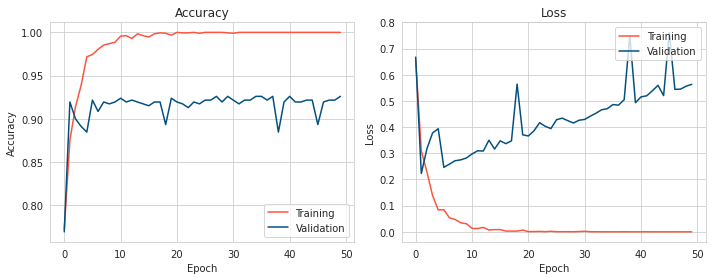

In [12]:
plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

In [13]:
def train_binary_model2():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1,activation='sigmoid',kernel_regularizer='l2'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [14]:
d1a_model2, d1a_history2 = train_binary_model2()

Epoch 1/50
103/115 [=========================>....] - ETA: 0s - loss: 0.6237 - accuracy: 0.7870
Epoch 1: val_accuracy improved from -inf to 0.84783, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 9ms/step - loss: 0.6329 - accuracy: 0.7870 - val_loss: 0.4061 - val_accuracy: 0.8478
Epoch 2/50
110/115 [===========================>..] - ETA: 0s - loss: 0.3717 - accuracy: 0.8744
Epoch 2: val_accuracy improved from 0.84783 to 0.89565, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 5ms/step - loss: 0.3915 - accuracy: 0.8685 - val_loss: 0.3439 - val_accuracy: 0.8957
Epoch 3/50
113/115 [============================>.] - ETA: 0s - loss: 0.2900 - accuracy: 0.9038
Epoch 3: val_accuracy did not improve from 0.89565
115/115 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.9038 - val_loss: 0

Best Model:
epoch: 9 , val_acc: 0.9217391014099121 , val_loss: 0.29529932141304016


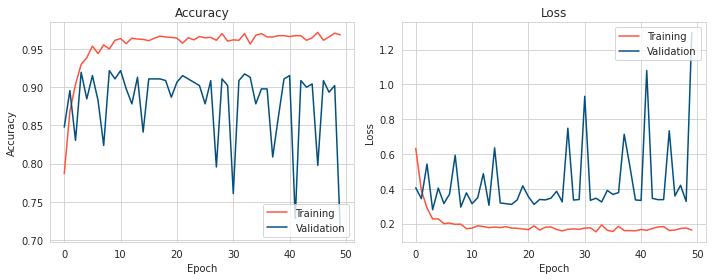

In [15]:
plot_metrics(d1a_history2) # rmsprop, sigmoid, with l2 regularization (0.01)

In [16]:
def train_binary_model3():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [17]:
d1a_model3, d1a_history3 = train_binary_model3() 

Epoch 1/50
111/115 [===========================>..] - ETA: 0s - loss: 1.5355 - accuracy: 0.7489
Epoch 1: val_accuracy improved from -inf to 0.85217, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 3s 16ms/step - loss: 1.5032 - accuracy: 0.7478 - val_loss: 0.3399 - val_accuracy: 0.8522
Epoch 2/50
111/115 [===========================>..] - ETA: 0s - loss: 0.5601 - accuracy: 0.8232
Epoch 2: val_accuracy did not improve from 0.85217
115/115 [==============================] - 1s 11ms/step - loss: 0.5591 - accuracy: 0.8228 - val_loss: 0.5358 - val_accuracy: 0.7739
Epoch 3/50
111/115 [===========================>..] - ETA: 0s - loss: 0.4774 - accuracy: 0.8429
Epoch 3: val_accuracy did not improve from 0.85217
115/115 [==============================] - 1s 11ms/step - loss: 0.4762 - accuracy: 0.8429 - val_loss: 0.4456 - val_accuracy: 0.8457
Epoch 4/50
114/115 [============================>.] - ETA: 0s - los

Best Model:
epoch: 9 , val_acc: 0.926086962223053 , val_loss: 0.30976954102516174


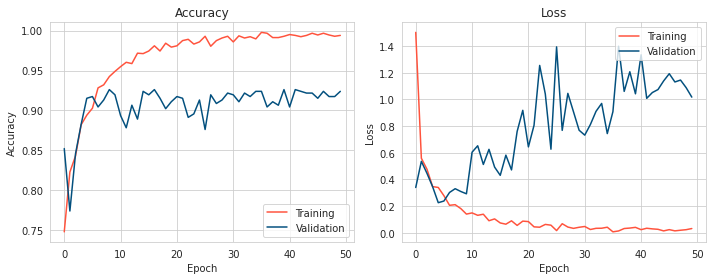

In [19]:
plot_metrics(d1a_history3) # rmsprop, sigmoid, with double dense and dropout layers

In [18]:
def train_binary_model4():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [20]:
d1a_model4, d1a_history4 = train_binary_model4() 

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 1.5011 - accuracy: 0.7158
Epoch 1: val_accuracy improved from -inf to 0.90217, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 3s 18ms/step - loss: 1.5011 - accuracy: 0.7158 - val_loss: 0.2715 - val_accuracy: 0.9022
Epoch 2/50
112/115 [============================>.] - ETA: 0s - loss: 0.5677 - accuracy: 0.7941
Epoch 2: val_accuracy did not improve from 0.90217
115/115 [==============================] - 1s 11ms/step - loss: 0.5662 - accuracy: 0.7946 - val_loss: 0.2820 - val_accuracy: 0.8913
Epoch 3/50
112/115 [============================>.] - ETA: 0s - loss: 0.5325 - accuracy: 0.8203
Epoch 3: val_accuracy did not improve from 0.90217
115/115 [==============================] - 1s 11ms/step - loss: 0.5386 - accuracy: 0.8185 - val_loss: 0.2571 - val_accuracy: 0.9000
Epoch 4/50
113/115 [============================>.] - ETA: 0s - los

Best Model:
epoch: 19 , val_acc: 0.9304347634315491 , val_loss: 0.3287333548069


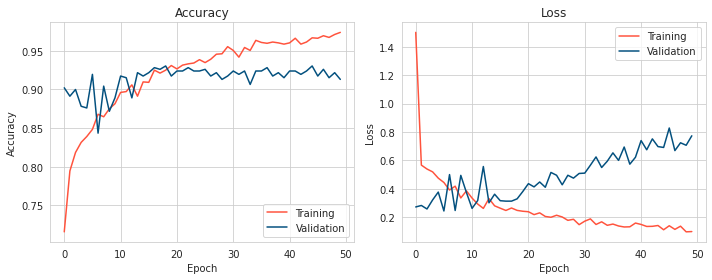

In [21]:
plot_metrics(d1a_history4) # rmsprop, sigmoid, with aggresive dropout (.75)

In [22]:
def train_binary_model5():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [23]:
d1a_model5, d1a_history5 = train_binary_model5() 

Epoch 1/50
114/115 [============================>.] - ETA: 0s - loss: 1.8750 - accuracy: 0.7264
Epoch 1: val_accuracy improved from -inf to 0.86957, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 3s 21ms/step - loss: 1.8644 - accuracy: 0.7261 - val_loss: 0.4090 - val_accuracy: 0.8696
Epoch 2/50
114/115 [============================>.] - ETA: 0s - loss: 1.1757 - accuracy: 0.7396
Epoch 2: val_accuracy did not improve from 0.86957
115/115 [==============================] - 2s 14ms/step - loss: 1.1791 - accuracy: 0.7386 - val_loss: 0.5067 - val_accuracy: 0.8087
Epoch 3/50
112/115 [============================>.] - ETA: 0s - loss: 0.9374 - accuracy: 0.7617
Epoch 3: val_accuracy improved from 0.86957 to 0.88696, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 2s 14ms/step - loss: 0.9368 - accuracy: 0.7630 - val_loss

Best Model:
epoch: 40 , val_acc: 0.917391300201416 , val_loss: 0.38732919096946716


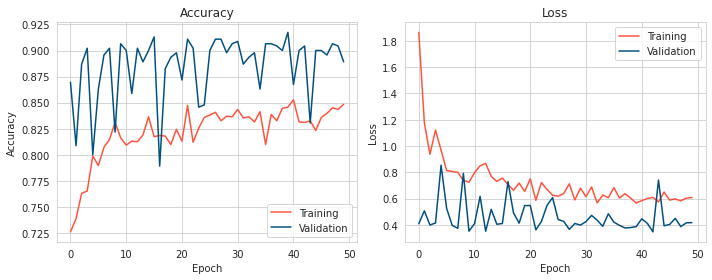

In [24]:
plot_metrics(d1a_history5) # rmsprop, sigmoid, with l2 = 0.001

In [25]:
def train_binary_model6():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizers.SGD(lr=0.001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [26]:
d1a_model6, d1a_history6 = train_binary_model6() 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
114/115 [============================>.] - ETA: 0s - loss: 1.2403 - accuracy: 0.6497
Epoch 1: val_accuracy improved from -inf to 0.82609, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 2s 17ms/step - loss: 1.2400 - accuracy: 0.6495 - val_loss: 0.9913 - val_accuracy: 0.8261
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 1.0422 - accuracy: 0.7359
Epoch 2: val_accuracy improved from 0.82609 to 0.86739, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 11ms/step - loss: 1.0422 - accuracy: 0.7359 - val_loss: 0.9093 - val_accuracy: 0.8674
Epoch 3/50
111/115 [===========================>..] - ETA: 0s - loss: 1.0249 - accuracy: 0.7252
Epoch 3: val_accuracy did not improve from 0.86739
115/115 [==============================] - 1s 10ms/step - loss: 1.0273 - accuracy: 0.7261 - val_loss

Best Model:
epoch: 40 , val_acc: 0.9217391014099121 , val_loss: 0.845717191696167


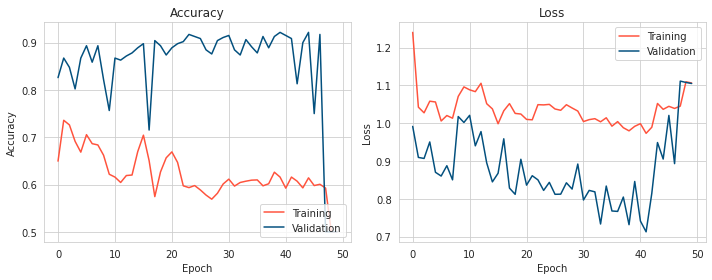

In [27]:
plot_metrics(d1a_history6) # sgd with lr = 0.001 and decay 1e-6, sigmoid, with l2 = 0.001

In [28]:
def train_binary_model7():

    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [29]:
d1a_model7, d1a_history7 = train_binary_model7()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 1.0852 - accuracy: 0.6880
Epoch 1: val_accuracy improved from -inf to 0.86522, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 3s 19ms/step - loss: 1.0852 - accuracy: 0.6880 - val_loss: 0.9039 - val_accuracy: 0.8652
Epoch 2/50
110/115 [===========================>..] - ETA: 0s - loss: 0.9158 - accuracy: 0.8182
Epoch 2: val_accuracy improved from 0.86522 to 0.87609, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
115/115 [==============================] - 1s 11ms/step - loss: 0.9168 - accuracy: 0.8190 - val_loss: 0.8448 - val_accuracy: 0.8761
Epoch 3/50
110/115 [===========================>..] - ETA: 0s - loss: 0.8734 - accuracy: 0.8415
Epoch 3: val_accuracy improved from 0.87609 to 0.88478, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/top_model_weights.hdf5
1

Best Model:
epoch: 43 , val_acc: 0.928260862827301 , val_loss: 0.7073684930801392


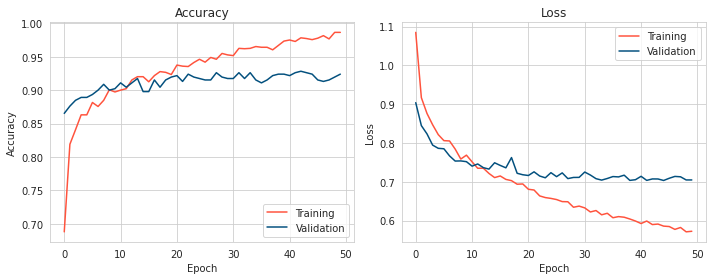

In [30]:
#Winner
plot_metrics(d1a_history7) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Fine Tuning

In [31]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=batch_size,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, mode='max')
    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=nb_epoch,
                              batch_size=batch_size,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [32]:
ft_model, ft_history = finetune_binary_model()

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 5.5836 - accuracy: 0.7489
Epoch 1: val_accuracy improved from -inf to 0.92857, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/ft_model.hdf5
115/115 [==============================] - 517s 4s/step - loss: 5.5836 - accuracy: 0.7489 - val_loss: 5.1985 - val_accuracy: 0.9286
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 5.5592 - accuracy: 0.7587
Epoch 2: val_accuracy did not improve from 0.92857
115/115 [==============================] - 52s 450ms/step - loss: 5.5592 - accuracy: 0.7587 - val_loss: 5.1988 - val_accuracy: 0.9263
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 5.5613 - accuracy: 0.7630
Epoch 3: val_accuracy improved from 0.92857 to 0.93080, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data1a/ft_model.hdf5
115/115 [========================

Best Model:
epoch: 8 , val_acc: 0.9330357313156128 , val_loss: 5.192643165588379


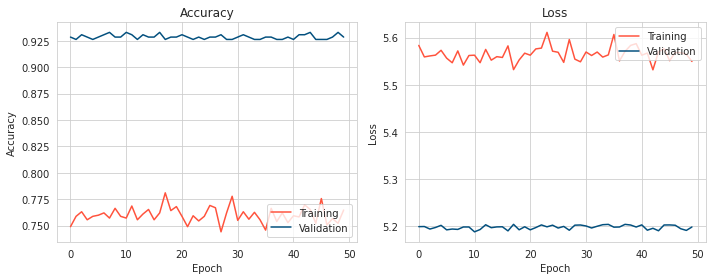

In [33]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Load Model Point

In [34]:
ft_model = load_model(location+'/ft_model.hdf5')

In [39]:
with open(location+'/top_history.txt') as f:    
    top_history = json.load(f)

In [40]:
with open(location+'/ft_history.txt') as f:    
    ft_history = json.load(f)

In [36]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [37]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [38]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm 

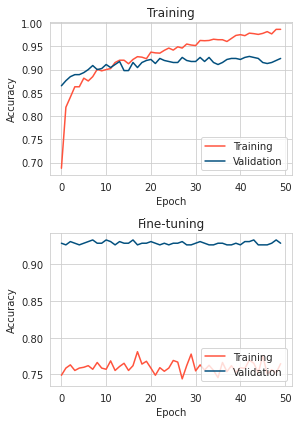

In [41]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 8 , val_acc: 0.9330357313156128 , val_loss: 5.192643165588379


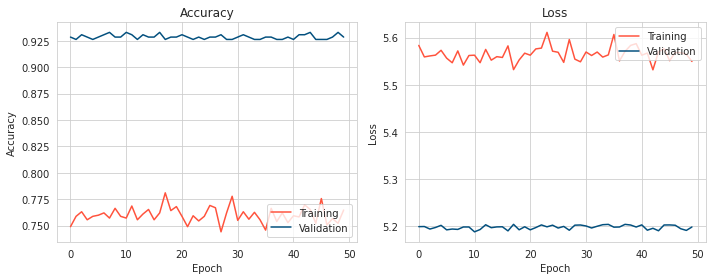

In [42]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [43]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1])

In [44]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 460 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.



              precision    recall  f1-score   support

           0       0.94      0.92      0.93       230
           1       0.92      0.94      0.93       230

    accuracy                           0.93       460
   macro avg       0.93      0.93      0.93       460
weighted avg       0.93      0.93      0.93       460




In [45]:
heatmap_labels = ['Damaged', 'Whole']

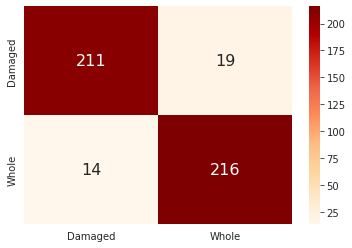

In [46]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [76]:
from urllib.request import urlretrieve

def car_categories_gate(image_path, model,option=1):
    if(option==1):
      urlretrieve(image_path, 'save.jpg')
      img = load_img('save.jpg', target_size=(256, 256))
    else:
      img = load_img(image_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists...")
    print(pred)
    if pred[0][0] <=.5:

        print("Validation complete - proceed to location and severity determination")
    else:
        print("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print("Hint: Try zooming in/out, using a different angle or different lighting")

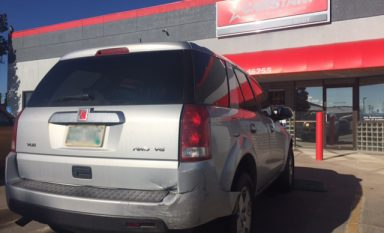

In [49]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [52]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Validating that damage exists...
[[0.1963235]]
Validation complete - proceed to location and severity determination


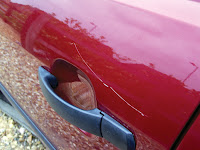

In [53]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [54]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Validating that damage exists...
[[0.5572712]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


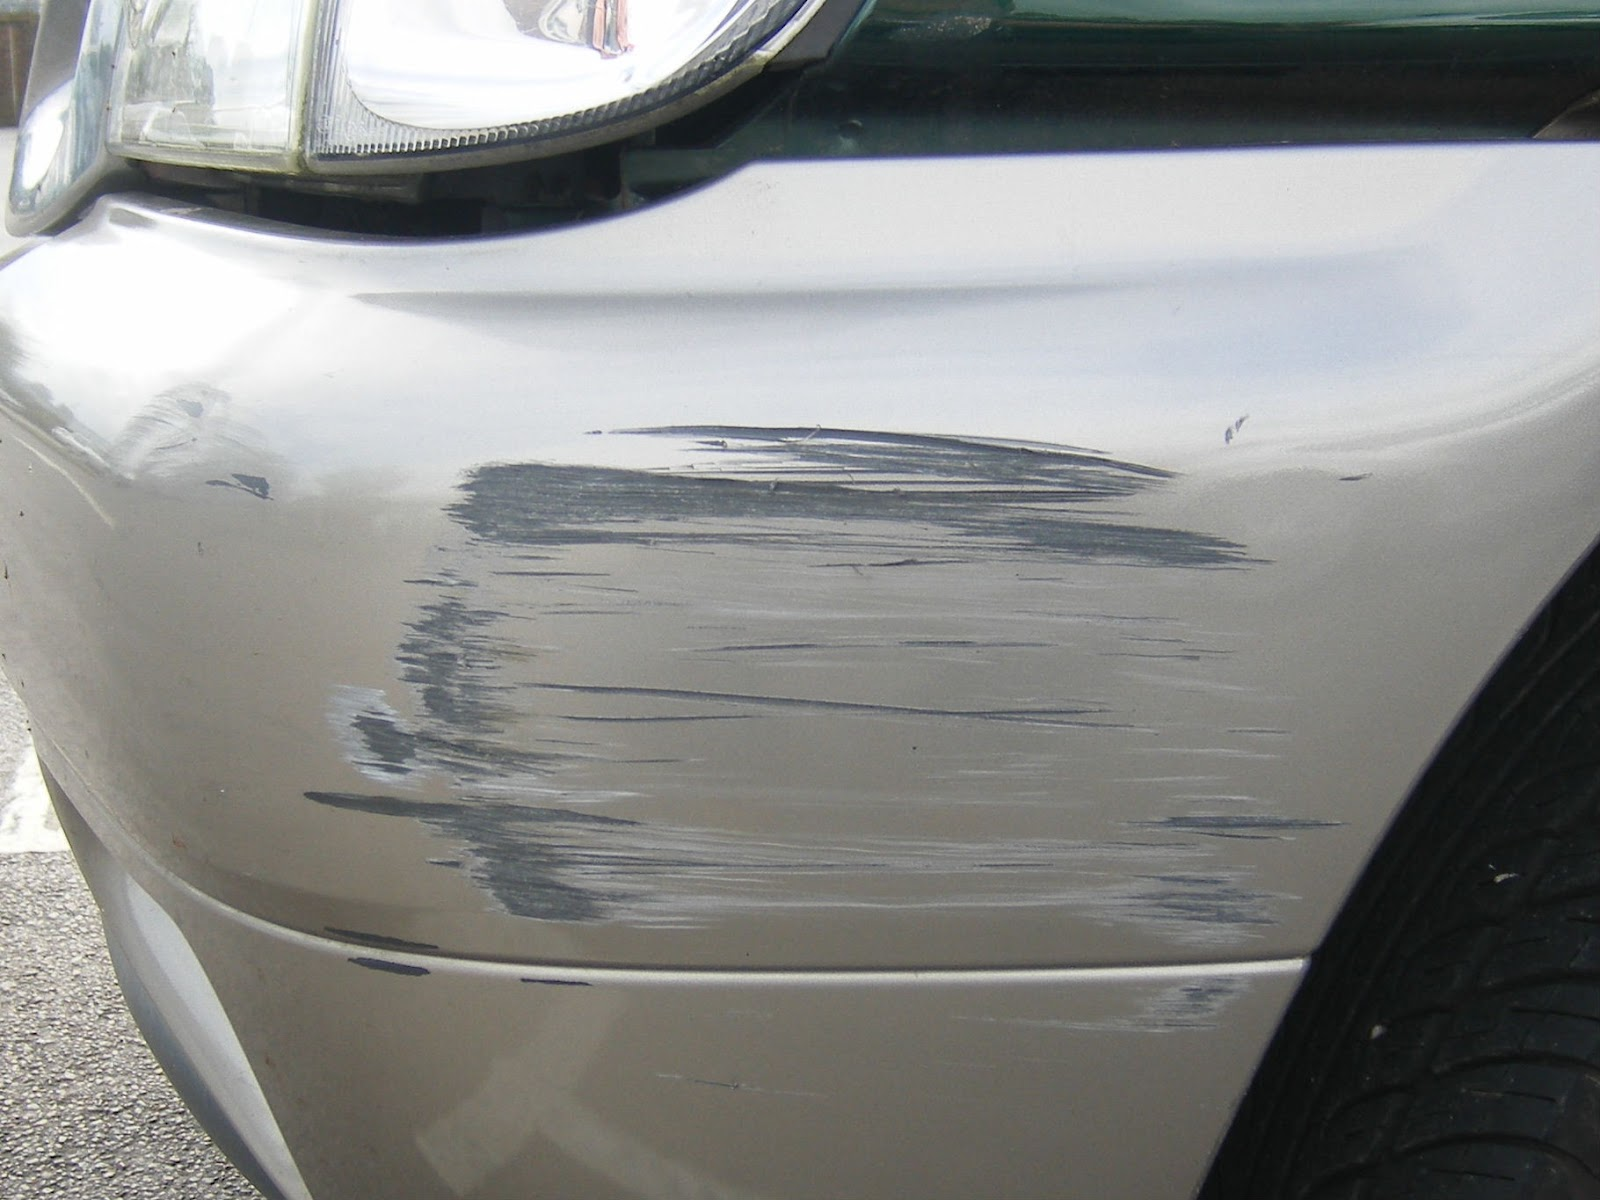

In [62]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

In [63]:
car_categories_gate('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', ft_model)

Validating that damage exists...
[[0.01391002]]
Validation complete - proceed to location and severity determination


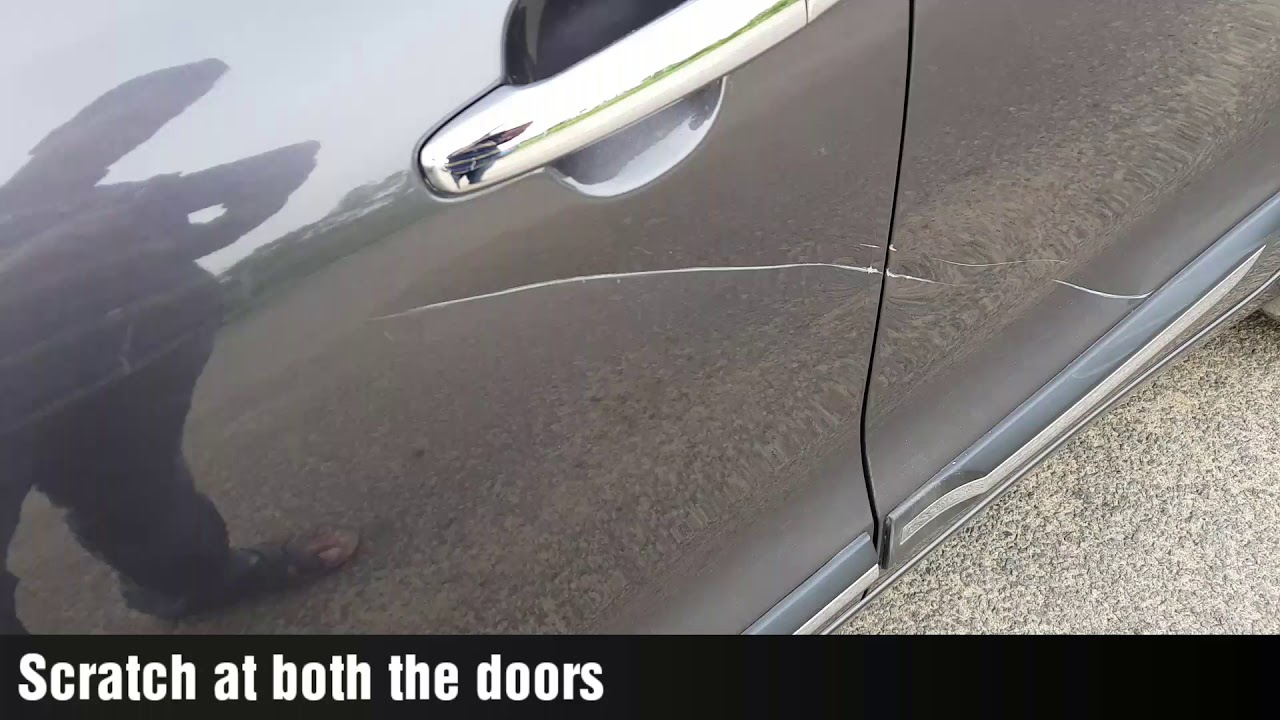

In [64]:
Image('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg')

In [65]:
car_categories_gate('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

Validating that damage exists...
[[0.1817829]]
Validation complete - proceed to location and severity determination


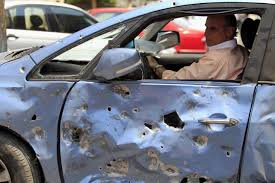

In [80]:
Image(location+'/validation/00-damage/0010.JPEG')

In [81]:
car_categories_gate(location+'/validation/00-damage/0005.JPEG', ft_model,0)

Validating that damage exists...
[[0.02825213]]
Validation complete - proceed to location and severity determination


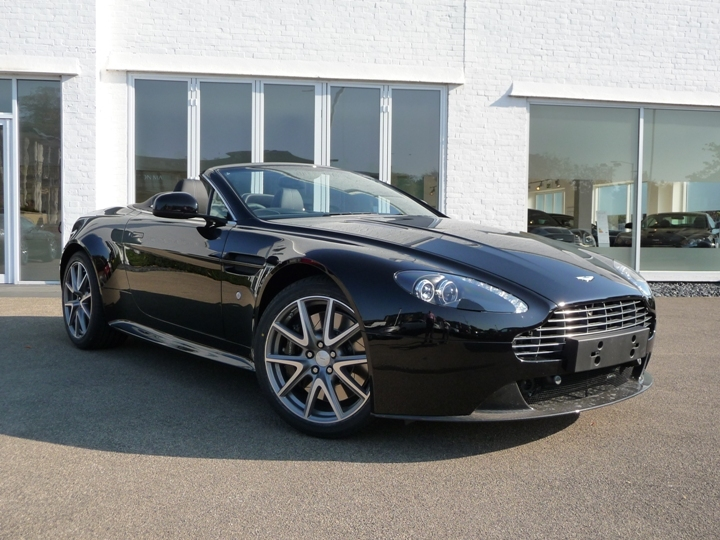

In [82]:
Image(location+'/validation/01-whole/0010.jpg')

In [84]:
car_categories_gate(location+'/validation/01-whole/0010.jpg', ft_model,0)

Validating that damage exists...
[[0.994412]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting
